In [1]:
!pip install tensorflowjs==2.8.0 --quiet

In [2]:
import tensorflow as tf
import tensorflowjs as tfjs

print(f"Current TensorFlow version: {tf.__version__}")
print(f"Current TensorFlow JS version: {tfjs.__version__}")
print(f"Keras version (via TensorFlow): {tf.keras.__version__}")

Current TensorFlow version: 2.1.0
Current TensorFlow JS version: 2.8.0
Keras version (via TensorFlow): 2.2.4-tf


# import libraries

In [3]:
# Import libraries
import json
import math
import os
import shutil # For file operations
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
import random
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

# Define source paths for the datasets

In [4]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Create working directory structure
output_base_dir = '/kaggle/working/balanced_xray_dataset'
os.makedirs(output_base_dir, exist_ok=True)

# Create temporary collection directories
temp_collections = {
    'tuberculosis': os.path.join(output_base_dir, 'temp_tuberculosis'),
    'normal': os.path.join(output_base_dir, 'temp_normal'), 
    'pneumonia': os.path.join(output_base_dir, 'temp_pneumonia')
}

for path in temp_collections.values():
    os.makedirs(path, exist_ok=True)

print("✅ Libraries imported and directories created!")
print(f"📁 Working directory: {output_base_dir}")

✅ Libraries imported and directories created!
📁 Working directory: /kaggle/working/balanced_xray_dataset


In [5]:
# Define all dataset paths and their structures
dataset_configs = {
    'tbx11k': {
        'path': '/kaggle/input/tbx11k-simplified/tbx11k-simplified',
        'type': 'csv_based',
        'csv_file': 'data.csv',
        'images_folder': 'images',
        'mapping': {'tb': 'tuberculosis', 'no_tb': 'normal'}
    },
    'shenzhen': {
        'path': '/kaggle/input/tuberculosis-chest-xrays-shenzhen',
        'type': 'csv_based', 
        'csv_file': 'shenzhen_metadata.csv',
        'images_folder': 'images/images',
        'mapping': {'normal': 'normal', 'other': 'tuberculosis'}  # everything not normal is TB
    },
    'tb_chest_db': {
        'path': '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database',
        'type': 'folder_based',
        'folders': {
            'Normal': 'normal',
            'Tuberculosis': 'tuberculosis'
        }
    },
    'covid_pneumonia_tb': {
        'path': '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis',
        'type': 'split_folder_based',
        'splits': ['train', 'val', 'test'],
        'folders': {
            'NORMAL': 'normal',
            'PNEUMONIA': 'pneumonia', 
            'TURBERCULOSIS': 'tuberculosis'
        }
    },
    'chest_xray_pneumonia': {
        'path': '/kaggle/input/chest-xray-pneumonia/chest_xray',
        'type': 'split_folder_based',
        'splits': ['train', 'val', 'test'],
        'folders': {
            'NORMAL': 'normal',
            'PNEUMONIA': 'pneumonia'
        }
    }
}

def collect_images_from_datasets():
    """Collect all images from all datasets and organize by class"""
    
    collected_images = defaultdict(list)
    
    for dataset_name, config in dataset_configs.items():
        print(f"\n📥 Processing {dataset_name}...")
        
        if config['type'] == 'csv_based':
            # Handle CSV-based datasets (TBX11K, Shenzhen)
            csv_path = os.path.join(config['path'], config['csv_file'])
            images_path = os.path.join(config['path'], config['images_folder'])
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                
                if dataset_name == 'tbx11k':
                    # TBX11K specific handling
                    for _, row in df.iterrows():
                        target = row['target'].lower()
                        if target in config['mapping']:
                            class_name = config['mapping'][target]
                            img_path = os.path.join(images_path, row['fname'])
                            if os.path.exists(img_path):
                                collected_images[class_name].append((img_path, dataset_name))
                
                elif dataset_name == 'shenzhen':
                    # Shenzhen specific handling
                    for _, row in df.iterrows():
                        findings = row['findings'].lower().strip()
                        if findings == 'normal':
                            class_name = 'normal'
                        else:
                            class_name = 'tuberculosis'  # everything else is TB
                        
                        img_path = os.path.join(images_path, row['study_id'])
                        if os.path.exists(img_path):
                            collected_images[class_name].append((img_path, dataset_name))
        
        elif config['type'] == 'folder_based':
            # Handle simple folder-based datasets (TB Chest DB)
            for folder_name, class_name in config['folders'].items():
                folder_path = os.path.join(config['path'], folder_name)
                if os.path.exists(folder_path):
                    for img_file in os.listdir(folder_path):
                        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            img_path = os.path.join(folder_path, img_file)
                            collected_images[class_name].append((img_path, dataset_name))
        
        elif config['type'] == 'split_folder_based':
            # Handle pre-split datasets (COVID+Pneumonia+TB, Chest X-ray Pneumonia)
            for split in config['splits']:
                split_path = os.path.join(config['path'], split)
                if os.path.exists(split_path):
                    for folder_name, class_name in config['folders'].items():
                        folder_path = os.path.join(split_path, folder_name)
                        if os.path.exists(folder_path):
                            for img_file in os.listdir(folder_path):
                                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                                    img_path = os.path.join(folder_path, img_file)
                                    collected_images[class_name].append((img_path, f"{dataset_name}_{split}"))
        
        # Print progress for this dataset
        dataset_counts = defaultdict(int)
        for class_name, images in collected_images.items():
            dataset_counts[class_name] += len([img for img in images if img[1].startswith(dataset_name)])
        
        for class_name, count in dataset_counts.items():
            if count > 0:
                print(f"  {class_name}: {count} images")
    
    return collected_images

# Collect all images
print("🔍 Scanning all datasets for images...")
all_collected_images = collect_images_from_datasets()

# Print final collection summary
print(f"\n📊 Total Images Collected:")
for class_name, images in all_collected_images.items():
    print(f"  {class_name.title()}: {len(images)} images")
    
    # Show distribution by dataset
    dataset_dist = defaultdict(int)
    for _, dataset in images:
        dataset_dist[dataset] += 1
    
    for dataset, count in sorted(dataset_dist.items()):
        print(f"    └─ {dataset}: {count}")

print(f"\n✅ All datasets scanned and catalogued!")

🔍 Scanning all datasets for images...

📥 Processing tbx11k...
  normal: 7600 images
  tuberculosis: 1211 images

📥 Processing shenzhen...
  normal: 326 images
  tuberculosis: 336 images

📥 Processing tb_chest_db...
  normal: 3500 images
  tuberculosis: 700 images

📥 Processing covid_pneumonia_tb...
  normal: 1583 images
  tuberculosis: 703 images
  pneumonia: 4273 images

📥 Processing chest_xray_pneumonia...
  normal: 1583 images
  pneumonia: 4273 images

📊 Total Images Collected:
  Normal: 14592 images
    └─ chest_xray_pneumonia_test: 234
    └─ chest_xray_pneumonia_train: 1341
    └─ chest_xray_pneumonia_val: 8
    └─ covid_pneumonia_tb_test: 234
    └─ covid_pneumonia_tb_train: 1341
    └─ covid_pneumonia_tb_val: 8
    └─ shenzhen: 326
    └─ tb_chest_db: 3500
    └─ tbx11k: 7600
  Tuberculosis: 2950 images
    └─ covid_pneumonia_tb_test: 41
    └─ covid_pneumonia_tb_train: 650
    └─ covid_pneumonia_tb_val: 12
    └─ shenzhen: 336
    └─ tb_chest_db: 700
    └─ tbx11k: 1211
  Pneu

In [6]:
# Copy all tuberculosis images to temporary collection folder
print("🦠 Copying all Tuberculosis images...")

tuberculosis_images = all_collected_images.get('tuberculosis', [])
tuberculosis_dest = temp_collections['tuberculosis']

# Copy all available tuberculosis images
copied_count = 0
failed_count = 0

for img_path, dataset_source in tqdm(tuberculosis_images, desc="Copying TB images"):
    try:
        # Create unique filename to avoid conflicts
        base_name = os.path.basename(img_path)
        unique_filename = f"{dataset_source}_{base_name}"
        dest_path = os.path.join(tuberculosis_dest, unique_filename)
        
        # Copy the file
        shutil.copy2(img_path, dest_path)
        copied_count += 1
        
    except Exception as e:
        print(f"❌ Failed to copy {img_path}: {e}")
        failed_count += 1

print(f"\n📋 Tuberculosis Images Summary:")
print(f"  ✅ Successfully copied: {copied_count}")
print(f"  ❌ Failed to copy: {failed_count}")
print(f"  📁 Total in collection: {len(os.listdir(tuberculosis_dest))}")

# Verify we have the expected count
actual_tb_count = len(os.listdir(tuberculosis_dest))
if actual_tb_count < 2538:
    print(f"⚠️  Warning: Only found {actual_tb_count} TB images, less than target 2538")
else:
    print(f"✅ Great! We have {actual_tb_count} TB images (target was 2538)")

Copying TB images:   0%|          | 13/2950 [00:00<00:23, 125.84it/s]

🦠 Copying all Tuberculosis images...


Copying TB images: 100%|██████████| 2950/2950 [00:36<00:00, 81.75it/s]


📋 Tuberculosis Images Summary:
  ✅ Successfully copied: 2950
  ❌ Failed to copy: 0
  📁 Total in collection: 2538
✅ Great! We have 2538 TB images (target was 2538)


In [7]:
# Copy 2538 normal images with smart distribution
print("✅ Copying Normal images with balanced distribution...")

normal_images = all_collected_images.get('normal', [])
normal_dest = temp_collections['normal']

# Analyze available normal images by dataset quality/preference
dataset_preferences = {
    # High quality datasets (prefer these)
    'chest_xray_pneumonia_train': 0.4,  # High quality, large dataset
    'chest_xray_pneumonia_val': 0.05,
    'chest_xray_pneumonia_test': 0.05,
    'tbx11k': 0.3,  # Good quality TB-focused dataset
    'shenzhen': 0.1,  # Smaller but good quality
    'tb_chest_db': 0.05,  # Smaller contribution
    'covid_pneumonia_tb_train': 0.03,
    'covid_pneumonia_tb_val': 0.01,
    'covid_pneumonia_tb_test': 0.01
}

# Group images by dataset
normal_by_dataset = defaultdict(list)
for img_path, dataset_source in normal_images:
    normal_by_dataset[dataset_source].append(img_path)

print(f"📊 Available Normal Images by Dataset:")
for dataset, images in normal_by_dataset.items():
    print(f"  {dataset}: {len(images)} images")

# Calculate target count per dataset based on preferences and availability
target_count = 2538
selected_images = []

print(f"\n📋 Selecting {target_count} normal images with smart distribution:")

for dataset, preference in dataset_preferences.items():
    if dataset in normal_by_dataset:
        available = len(normal_by_dataset[dataset])
        target_from_this = int(target_count * preference)
        actual_from_this = min(target_from_this, available)
        
        # Randomly sample from this dataset
        random.shuffle(normal_by_dataset[dataset])
        selected_from_this = normal_by_dataset[dataset][:actual_from_this]
        
        for img_path in selected_from_this:
            selected_images.append((img_path, dataset))
        
        print(f"  {dataset}: {actual_from_this}/{available} images (target: {target_from_this})")

# If we don't have enough, fill from remaining datasets
remaining_needed = target_count - len(selected_images)
if remaining_needed > 0:
    print(f"\n🔄 Need {remaining_needed} more images, filling from remaining...")
    
    # Collect unused images
    used_paths = {img[0] for img in selected_images}
    unused_images = [(path, dataset) for dataset, paths in normal_by_dataset.items() 
                    for path in paths if path not in used_paths]
    
    random.shuffle(unused_images)
    additional_images = unused_images[:remaining_needed]
    selected_images.extend(additional_images)
    
    print(f"  Added {len(additional_images)} additional images")

# Now copy the selected images
print(f"\n📥 Copying {len(selected_images)} selected normal images...")

copied_count = 0
failed_count = 0

for img_path, dataset_source in tqdm(selected_images, desc="Copying normal images"):
    try:
        # Create unique filename
        base_name = os.path.basename(img_path)
        unique_filename = f"{dataset_source}_{base_name}"
        dest_path = os.path.join(normal_dest, unique_filename)
        
        # Copy the file
        shutil.copy2(img_path, dest_path)
        copied_count += 1
        
    except Exception as e:
        print(f"❌ Failed to copy {img_path}: {e}")
        failed_count += 1

print(f"\n📋 Normal Images Summary:")
print(f"  ✅ Successfully copied: {copied_count}")
print(f"  ❌ Failed to copy: {failed_count}")
print(f"  📁 Total in collection: {len(os.listdir(normal_dest))}")
print(f"  🎯 Target was: {target_count}")

Copying normal images:   0%|          | 0/2538 [00:00<?, ?it/s]

✅ Copying Normal images with balanced distribution...
📊 Available Normal Images by Dataset:
  tbx11k: 7600 images
  shenzhen: 326 images
  tb_chest_db: 3500 images
  covid_pneumonia_tb_train: 1341 images
  covid_pneumonia_tb_val: 8 images
  covid_pneumonia_tb_test: 234 images
  chest_xray_pneumonia_train: 1341 images
  chest_xray_pneumonia_val: 8 images
  chest_xray_pneumonia_test: 234 images

📋 Selecting 2538 normal images with smart distribution:
  chest_xray_pneumonia_train: 1015/1341 images (target: 1015)
  chest_xray_pneumonia_val: 8/8 images (target: 126)
  chest_xray_pneumonia_test: 126/234 images (target: 126)
  tbx11k: 761/7600 images (target: 761)
  shenzhen: 253/326 images (target: 253)
  tb_chest_db: 126/3500 images (target: 126)
  covid_pneumonia_tb_train: 76/1341 images (target: 76)
  covid_pneumonia_tb_val: 8/8 images (target: 25)
  covid_pneumonia_tb_test: 25/234 images (target: 25)

🔄 Need 140 more images, filling from remaining...
  Added 140 additional images

📥 Copy

Copying normal images: 100%|██████████| 2538/2538 [00:43<00:00, 57.98it/s]


📋 Normal Images Summary:
  ✅ Successfully copied: 2538
  ❌ Failed to copy: 0
  📁 Total in collection: 2538
  🎯 Target was: 2538


In [8]:
# Copy 2538 pneumonia images with smart distribution
print("🫁 Copying Pneumonia images with balanced distribution...")

pneumonia_images = all_collected_images.get('pneumonia', [])
pneumonia_dest = temp_collections['pneumonia']

# Analyze available pneumonia images by dataset
pneumonia_by_dataset = defaultdict(list)
for img_path, dataset_source in pneumonia_images:
    pneumonia_by_dataset[dataset_source].append(img_path)

print(f"📊 Available Pneumonia Images by Dataset:")
total_available = 0
for dataset, images in pneumonia_by_dataset.items():
    print(f"  {dataset}: {len(images)} images")
    total_available += len(images)

print(f"  📊 Total Available: {total_available} images")

# Dataset preferences for pneumonia (prioritize high-quality datasets)
pneumonia_preferences = {
    'chest_xray_pneumonia_train': 0.85,  # Main high-quality pneumonia dataset
    'chest_xray_pneumonia_val': 0.05,
    'chest_xray_pneumonia_test': 0.05,
    'covid_pneumonia_tb_train': 0.03,
    'covid_pneumonia_tb_val': 0.01,
    'covid_pneumonia_tb_test': 0.01
}

# Calculate target count per dataset
target_count = 2538
selected_images = []

print(f"\n📋 Selecting {target_count} pneumonia images with smart distribution:")

for dataset, preference in pneumonia_preferences.items():
    if dataset in pneumonia_by_dataset:
        available = len(pneumonia_by_dataset[dataset])
        target_from_this = int(target_count * preference)
        actual_from_this = min(target_from_this, available)
        
        # Randomly sample from this dataset
        random.shuffle(pneumonia_by_dataset[dataset])
        selected_from_this = pneumonia_by_dataset[dataset][:actual_from_this]
        
        for img_path in selected_from_this:
            selected_images.append((img_path, dataset))
        
        print(f"  {dataset}: {actual_from_this}/{available} images (target: {target_from_this})")

# Fill remaining if needed
remaining_needed = target_count - len(selected_images)
if remaining_needed > 0:
    print(f"\n🔄 Need {remaining_needed} more images, filling from remaining...")
    
    # Collect unused images
    used_paths = {img[0] for img in selected_images}
    unused_images = [(path, dataset) for dataset, paths in pneumonia_by_dataset.items() 
                    for path in paths if path not in used_paths]
    
    random.shuffle(unused_images)
    additional_images = unused_images[:remaining_needed]
    selected_images.extend(additional_images)
    
    print(f"  Added {len(additional_images)} additional images")

# Trim if we have too many
if len(selected_images) > target_count:
    print(f"🔄 Trimming {len(selected_images) - target_count} excess images...")
    random.shuffle(selected_images)
    selected_images = selected_images[:target_count]

# Copy the selected images
print(f"\n📥 Copying {len(selected_images)} selected pneumonia images...")

copied_count = 0
failed_count = 0

for img_path, dataset_source in tqdm(selected_images, desc="Copying pneumonia images"):
    try:
        # Create unique filename
        base_name = os.path.basename(img_path)
        unique_filename = f"{dataset_source}_{base_name}"
        dest_path = os.path.join(pneumonia_dest, unique_filename)
        
        # Copy the file
        shutil.copy2(img_path, dest_path)
        copied_count += 1
        
    except Exception as e:
        print(f"❌ Failed to copy {img_path}: {e}")
        failed_count += 1

print(f"\n📋 Pneumonia Images Summary:")
print(f"  ✅ Successfully copied: {copied_count}")
print(f"  ❌ Failed to copy: {failed_count}")
print(f"  📁 Total in collection: {len(os.listdir(pneumonia_dest))}")
print(f"  🎯 Target was: {target_count}")

Copying pneumonia images:   0%|          | 0/2538 [00:00<?, ?it/s]

🫁 Copying Pneumonia images with balanced distribution...
📊 Available Pneumonia Images by Dataset:
  covid_pneumonia_tb_train: 3875 images
  covid_pneumonia_tb_val: 8 images
  covid_pneumonia_tb_test: 390 images
  chest_xray_pneumonia_train: 3875 images
  chest_xray_pneumonia_val: 8 images
  chest_xray_pneumonia_test: 390 images
  📊 Total Available: 8546 images

📋 Selecting 2538 pneumonia images with smart distribution:
  chest_xray_pneumonia_train: 2157/3875 images (target: 2157)
  chest_xray_pneumonia_val: 8/8 images (target: 126)
  chest_xray_pneumonia_test: 126/390 images (target: 126)
  covid_pneumonia_tb_train: 76/3875 images (target: 76)
  covid_pneumonia_tb_val: 8/8 images (target: 25)
  covid_pneumonia_tb_test: 25/390 images (target: 25)

🔄 Need 138 more images, filling from remaining...
  Added 138 additional images

📥 Copying 2538 selected pneumonia images...


Copying pneumonia images: 100%|██████████| 2538/2538 [00:18<00:00, 137.97it/s]


📋 Pneumonia Images Summary:
  ✅ Successfully copied: 2538
  ❌ Failed to copy: 0
  📁 Total in collection: 2538
  🎯 Target was: 2538


In [9]:
# Distribute collected images into train/val/test splits
print("📊 Creating balanced train/val/test splits...")

# Define split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15  
TEST_RATIO = 0.15

# Create final directory structure
final_data_dir = os.path.join(output_base_dir, 'final')
categories = ['Normal', 'Tuberculosis', 'Pneumonia']

for split in ['train', 'val', 'test']:
    for category in categories:
        os.makedirs(os.path.join(final_data_dir, split, category), exist_ok=True)

def split_and_copy_images(source_dir, category_name, target_base_dir):
    """Split images from source directory into train/val/test"""
    
    # Get all images from source
    all_images = [f for f in os.listdir(source_dir) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Shuffle for random distribution
    random.shuffle(all_images)
    
    # Calculate split sizes
    total = len(all_images)
    train_size = int(total * TRAIN_RATIO)
    val_size = int(total * VAL_RATIO)
    test_size = total - train_size - val_size  # Remaining goes to test
    
    # Split the images
    train_images = all_images[:train_size]
    val_images = all_images[train_size:train_size + val_size]
    test_images = all_images[train_size + val_size:]
    
    print(f"\n📁 {category_name} Distribution:")
    print(f"  Train: {len(train_images)} images ({len(train_images)/total*100:.1f}%)")
    print(f"  Val:   {len(val_images)} images ({len(val_images)/total*100:.1f}%)")
    print(f"  Test:  {len(test_images)} images ({len(test_images)/total*100:.1f}%)")
    
    # Copy images to respective directories
    splits = {
        'train': train_images,
        'val': val_images, 
        'test': test_images
    }
    
    copied_counts = {'train': 0, 'val': 0, 'test': 0}
    
    for split_name, image_list in splits.items():
        dest_dir = os.path.join(target_base_dir, split_name, category_name)
        
        for img_file in tqdm(image_list, desc=f"Copying {category_name} to {split_name}"):
            try:
                src_path = os.path.join(source_dir, img_file)
                dest_path = os.path.join(dest_dir, img_file)
                shutil.copy2(src_path, dest_path)
                copied_counts[split_name] += 1
            except Exception as e:
                print(f"❌ Failed to copy {img_file}: {e}")
    
    return copied_counts

# Process each category
total_stats = defaultdict(lambda: defaultdict(int))

# Process Tuberculosis
print("🦠 Processing Tuberculosis images...")
tb_stats = split_and_copy_images(
    temp_collections['tuberculosis'], 
    'Tuberculosis', 
    final_data_dir
)
for split, count in tb_stats.items():
    total_stats[split]['Tuberculosis'] = count

# Process Normal
print("\n✅ Processing Normal images...")
normal_stats = split_and_copy_images(
    temp_collections['normal'], 
    'Normal', 
    final_data_dir
)
for split, count in normal_stats.items():
    total_stats[split]['Normal'] = count

# Process Pneumonia
print("\n🫁 Processing Pneumonia images...")
pneumonia_stats = split_and_copy_images(
    temp_collections['pneumonia'], 
    'Pneumonia', 
    final_data_dir
)
for split, count in pneumonia_stats.items():
    total_stats[split]['Pneumonia'] = count

# Clean up temporary directories
print("\n🧹 Cleaning up temporary directories...")
for temp_dir in temp_collections.values():
    shutil.rmtree(temp_dir)

# Final summary
print("\n🎉 FINAL BALANCED DATASET SUMMARY:")
print("="*50)

for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()}:")
    split_total = 0
    for category in categories:
        count = total_stats[split][category]
        split_total += count
        print(f"  {category:12}: {count:4d} images")
    print(f"  {'TOTAL':12}: {split_total:4d} images")

# Verify balance
print(f"\n📊 Class Balance Check:")
for category in categories:
    category_total = sum(total_stats[split][category] for split in ['train', 'val', 'test'])
    print(f"  {category}: {category_total} total images")

print(f"\n✅ Balanced dataset created successfully!")
print(f"📁 Final dataset location: {final_data_dir}")

# Update paths for model training
train_dir = os.path.join(final_data_dir, 'train')
val_dir = os.path.join(final_data_dir, 'val') 
test_dir = os.path.join(final_data_dir, 'test')

print(f"\n📍 Directory paths for model training:")
print(f"  Train: {train_dir}")
print(f"  Val:   {val_dir}")
print(f"  Test:  {test_dir}")

Copying Tuberculosis to train:   0%|          | 0/1776 [00:00<?, ?it/s]

📊 Creating balanced train/val/test splits...
🦠 Processing Tuberculosis images...

📁 Tuberculosis Distribution:
  Train: 1776 images (70.0%)
  Val:   380 images (15.0%)
  Test:  382 images (15.1%)


Copying Normal to train:   5%|▌         | 93/1776 [00:00<00:01, 880.79it/s]


✅ Processing Normal images...

📁 Normal Distribution:
  Train: 1776 images (70.0%)
  Val:   380 images (15.0%)
  Test:  382 images (15.1%)


Copying Pneumonia to train:  23%|██▎       | 417/1776 [00:00<00:00, 4167.93it/s]


🫁 Processing Pneumonia images...

📁 Pneumonia Distribution:
  Train: 1776 images (70.0%)
  Val:   380 images (15.0%)
  Test:  382 images (15.1%)


Copying Pneumonia to test: 100%|██████████| 382/382 [00:00<00:00, 3258.84it/s]



🧹 Cleaning up temporary directories...

🎉 FINAL BALANCED DATASET SUMMARY:

TRAIN:
  Normal      : 1776 images
  Tuberculosis: 1776 images
  Pneumonia   : 1776 images
  TOTAL       : 5328 images

VAL:
  Normal      :  380 images
  Tuberculosis:  380 images
  Pneumonia   :  380 images
  TOTAL       : 1140 images

TEST:
  Normal      :  382 images
  Tuberculosis:  382 images
  Pneumonia   :  382 images
  TOTAL       : 1146 images

📊 Class Balance Check:
  Normal: 2538 total images
  Tuberculosis: 2538 total images
  Pneumonia: 2538 total images

✅ Balanced dataset created successfully!
📁 Final dataset location: /kaggle/working/balanced_xray_dataset/final

📍 Directory paths for model training:
  Train: /kaggle/working/balanced_xray_dataset/final/train
  Val:   /kaggle/working/balanced_xray_dataset/final/val
  Test:  /kaggle/working/balanced_xray_dataset/final/test


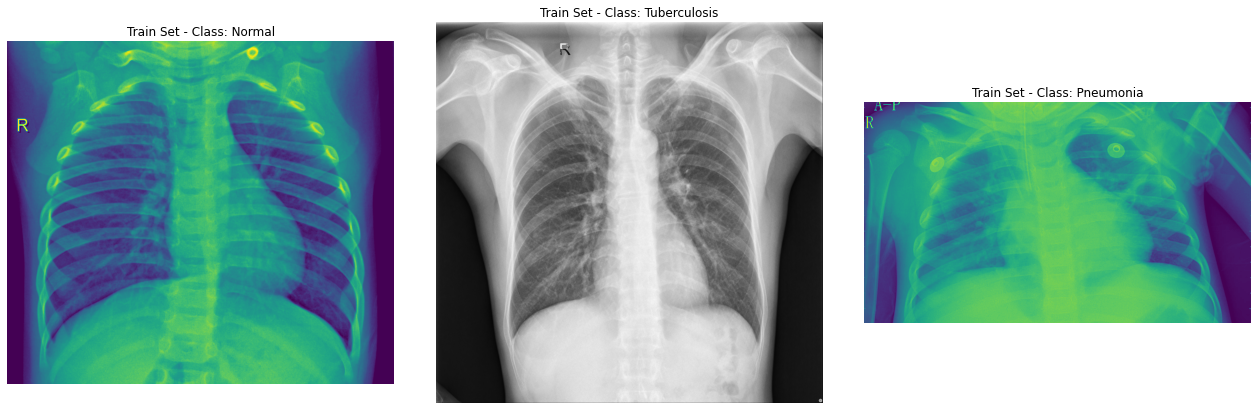

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6)) # 1 row, 3 columns for 3 classes
ax = ax.ravel()
plt.tight_layout()

for i, category in enumerate(categories):
    set_path = train_dir 
    try:
        img_file = os.path.join(set_path, category, os.listdir(os.path.join(set_path, category))[0])
        ax[i].imshow(plt.imread(img_file))
        ax[i].set_title(f'Train Set - Class: {category}')
        ax[i].axis('off')
    except IndexError:
        ax[i].set_title(f'Train Set - No images for {category}')
        ax[i].axis('off')
    except FileNotFoundError:
        ax[i].set_title(f'Train Set - Path not found for {category}')
        ax[i].axis('off')
plt.show()

In [11]:
IMAGE_SIZE = 150
BATCH_SIZE = 32 # You can adjust this

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # ✅ Use 'sparse'
    classes=sorted(categories),
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # ✅ Use 'sparse'
    classes=sorted(categories),
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # ✅ Use 'sparse'
    classes=sorted(categories),
    shuffle=False
)


# Verify class indices
print("Class Indices:", train_generator.class_indices)

Found 5328 images belonging to 3 classes.
Found 1140 images belonging to 3 classes.
Found 1146 images belonging to 3 classes.
Class Indices: {'Normal': 0, 'Pneumonia': 1, 'Tuberculosis': 2}


In [12]:
def build_multilabel_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=3, lr=1e-4):
    """
    Build a multi-label classification model using VGG16 backbone
    - Uses sigmoid activation (not softmax)
    - Each class gets independent probability
    - Probabilities DON'T need to sum to 100%
    """
    # Load VGG16 base model
    base_vgg16 = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=input_shape
    )
    
    model = Sequential([
        base_vgg16,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  
    ])
    
    return model

# Instantiate the NEW model
num_classes = len(categories)
model = build_multilabel_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=num_classes, lr=1e-4)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 14,846,787
Trainable params: 14,846,787
Non-trainable params: 0
_________________________________________________________________


In [13]:
import numpy as np
from tensorflow.keras.utils import Sequence

class MultiLabelGenerator(Sequence):
    """
    Custom generator that converts single-class labels to multi-label format
    """
    def __init__(self, base_generator, class_indices, multi_label_rules=None):
        self.base_generator = base_generator
        self.class_indices = class_indices
        self.num_classes = len(class_indices)
        
        # Default rules: if no multi-label rules provided, use single-label mapping
        self.multi_label_rules = multi_label_rules or self._create_default_rules()
        
    def _create_default_rules(self):
        """
        Create default single-label to multi-label mapping
        You can customize this based on medical knowledge
        """
        return {
            'Normal': [1.0, 0.0, 0.0],      # 100% Normal, 0% others
            'Pneumonia': [0.1, 1.0, 0.2],  # 10% Normal, 100% Pneumonia, 20% TB (co-occurrence)  
            'Tuberculosis': [0.1, 0.3, 1.0] # 10% Normal, 30% Pneumonia, 100% TB (co-occurrence)
        }
    
    def __len__(self):
        return len(self.base_generator)
    
    def __getitem__(self, index):
        # Get batch from base generator
        batch_x, batch_y_single = self.base_generator[index]
        batch_size = len(batch_x)
        
        # Convert single labels to multi-label format
        batch_y_multi = np.zeros((batch_size, self.num_classes))
        
        for i, class_index in enumerate(batch_y_single):
            class_index = int(class_index)
            # Get class name from index
            class_name = [k for k, v in self.class_indices.items() if v == class_index][0]
            # Apply multi-label rule
            batch_y_multi[i] = self.multi_label_rules[class_name]
        
        return batch_x, batch_y_multi
    
    def on_epoch_end(self):
        self.base_generator.on_epoch_end()

# Create multi-label generators
train_ml_generator = MultiLabelGenerator(
    train_generator, 
    train_generator.class_indices,
    multi_label_rules={
        'Normal': [0.9, 0.05, 0.05],     # Mostly normal, slight chance of others
        'Pneumonia': [0.1, 0.9, 0.3],   # Strong pneumonia, some TB co-occurrence
        'Tuberculosis': [0.1, 0.4, 0.9] # Strong TB, some pneumonia co-occurrence
    }
)

val_ml_generator = MultiLabelGenerator(validation_generator, validation_generator.class_indices)
test_ml_generator = MultiLabelGenerator(test_generator, test_generator.class_indices)

print("Multi-label generators created!")
print("Training samples:", len(train_ml_generator))
print("Validation samples:", len(val_ml_generator)) 
print("Test samples:", len(test_ml_generator))

Multi-label generators created!
Training samples: 167
Validation samples: 36
Test samples: 36


In [14]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Custom loss to discourage Normal + Disease predictions
def constrained_binary_crossentropy(y_true, y_pred):
    # Standard binary crossentropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Extract predicted probabilities
    normal = y_pred[:, 0]        # Assuming class order: [Normal, Pneumonia, Tuberculosis]
    pneumonia = y_pred[:, 1]
    tb = y_pred[:, 2]

    # Penalize when Normal and any disease are predicted together
    disease = tf.maximum(pneumonia, tb)
    conflict_penalty = normal * disease  # High if both Normal and Disease predicted

    # Return combined loss (0.3 = penalty weight, tune as needed)
    return bce + 0.3 * conflict_penalty

# Compile with custom loss
model.compile(
    optimizer='adam',
    loss=constrained_binary_crossentropy,
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


print("✅ Model compiled with custom constrained loss to reduce Normal+Disease errors.")


✅ Model compiled with custom constrained loss to reduce Normal+Disease errors.


In [15]:
# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy', depending on your goal
    patience=5,               # stop after 5 epochs with no improvement
    restore_best_weights=True # rollback to the best model
)

# Increase epochs (won’t always run all of them if early stopping triggers)
EPOCHS = 50

# Train with early stopping
history = model.fit(
    train_ml_generator,
    steps_per_epoch=len(train_ml_generator),
    epochs=EPOCHS,
    validation_data=val_ml_generator,
    validation_steps=len(val_ml_generator),
    callbacks=[early_stop]
)

print("✅ Multi-label training completed with early stopping!")

Train for 167 steps, validate for 36 steps
Epoch 1/50
167/167 [==============================] - 122s 731ms/step - loss: 0.7487 - accuracy: 0.3281 - precision: 1.0000 - recall: 0.0231 - val_loss: 0.7217 - val_accuracy: 0.3447 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
167/167 [==============================] - 120s 717ms/step - loss: 0.7002 - accuracy: 0.4566 - precision: 1.0000 - recall: 0.0887 - val_loss: 0.6489 - val_accuracy: 0.6088 - val_precision: 0.9774 - val_recall: 0.1139
Epoch 3/50
167/167 [==============================] - 117s 701ms/step - loss: 0.6527 - accuracy: 0.6222 - precision: 1.0000 - recall: 0.1639 - val_loss: 0.5820 - val_accuracy: 0.7202 - val_precision: 0.9131 - val_recall: 0.2489
Epoch 4/50
167/167 [==============================] - 116s 696ms/step - loss: 0.6325 - accuracy: 0.6866 - precision: 1.0000 - recall: 0.2045 - val_loss: 0.5385 - val_accuracy: 0.7439 - val_precision: 0.9750 - val_recall: 0.2929
Epoch 5/50
167/167 [=================

In [16]:
import numpy as np
from sklearn.metrics import classification_report, multilabel_confusion_matrix

print("\nEvaluating Multi-Label Model on Test Set...")
test_loss, test_accuracy, test_precision, test_recall  = model.evaluate(test_ml_generator, steps=len(test_ml_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Get predictions
Y_pred = model.predict(test_ml_generator, steps=len(test_ml_generator))
print(f"Prediction shape: {Y_pred.shape}")

# Get true labels
Y_true = []
for i in range(len(test_ml_generator)):
    _, y_batch = test_ml_generator[i]
    Y_true.extend(y_batch)
Y_true = np.array(Y_true)
print(f"True labels shape: {Y_true.shape}")

# Convert both Y_true and Y_pred to binary (threshold = 0.5)
Y_true_binary = (Y_true > 0.5).astype(int)
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Multi-label evaluation
print("\n=== MULTI-LABEL EVALUATION ===")
class_names = ['Normal', 'Pneumonia', 'Tuberculosis']

# Per-class evaluation
for i, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    print(f"  True positives: {np.sum((Y_true_binary[:, i] == 1) & (Y_pred_binary[:, i] == 1))}")
    print(f"  False positives: {np.sum((Y_true_binary[:, i] == 0) & (Y_pred_binary[:, i] == 1))}")
    print(f"  False negatives: {np.sum((Y_true_binary[:, i] == 1) & (Y_pred_binary[:, i] == 0))}")
    print(f"  Average probability: {np.mean(Y_pred[:, i]):.3f}")

# Confusion matrices for each class
confusion_matrices = multilabel_confusion_matrix(Y_true_binary, Y_pred_binary)
for i, (class_name, cm) in enumerate(zip(class_names, confusion_matrices)):
    print(f"\nConfusion Matrix for {class_name}:")
    print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_true_binary, Y_pred_binary, target_names=class_names))


Evaluating Multi-Label Model on Test Set...
36/36 [==============================] - 19s 521ms/step - loss: 0.3946 - accuracy: 0.8997 - precision: 0.9665 - recall: 0.3998
Test Loss: 0.3946
Test Accuracy: 0.8997
Test Precision: 0.9665
Test Recall: 0.3998
Prediction shape: (1146, 3)
True labels shape: (1146, 3)

=== MULTI-LABEL EVALUATION ===

Normal:
  True positives: 324
  False positives: 45
  False negatives: 58
  Average probability: 0.330

Pneumonia:
  True positives: 360
  False positives: 18
  False negatives: 22
  Average probability: 0.439

Tuberculosis:
  True positives: 324
  False positives: 35
  False negatives: 58
  Average probability: 0.393

Confusion Matrix for Normal:
[[719  45]
 [ 58 324]]

Confusion Matrix for Pneumonia:
[[746  18]
 [ 22 360]]

Confusion Matrix for Tuberculosis:
[[729  35]
 [ 58 324]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.85      0.86       382
   Pneumonia       0.95      0.94 

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
def predict_multilabel_diseases(model, img_path, confidence_threshold=0.5, image_size=150):
    """
    Multi-label prediction function - can detect multiple diseases simultaneously
    """
    # Preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    # Make prediction - now returns independent probabilities
    predictions = model.predict(img_array, verbose=0)[0]
    
    # Class names
    class_names = ['Normal', 'Pneumonia', 'Tuberculosis']
    
    print("=== MULTI-LABEL PREDICTIONS ===")
    print(f"Image: {img_path}")
    print("\nIndependent Probabilities:")
    
    detections = {}
    for i, (name, prob) in enumerate(zip(class_names, predictions)):
        is_detected = prob > confidence_threshold
        print(f"  {name}: {prob:.1%} {'✓ DETECTED' if is_detected else ''}")
        
        detections[name.lower()] = {
            'detected': is_detected,
            'confidence': float(prob)
        }
    
    # Show what's detected
    detected_diseases = [name for name, data in detections.items() if data['detected']]
    
    if len(detected_diseases) == 0:
        print(f"\n🟢 NO DISEASES DETECTED (all below {confidence_threshold:.0%} threshold)")
    elif len(detected_diseases) == 1:
        disease = detected_diseases[0].title()
        conf = detections[detected_diseases[0]]['confidence']
        print(f"\n🔵 SINGLE DISEASE: {disease} ({conf:.1%})")
    else:
        diseases_str = ", ".join([d.title() for d in detected_diseases])
        print(f"\n🔴 MULTIPLE DISEASES DETECTED: {diseases_str}")
        print("This patient may have co-occurring conditions!")
    
    return detections

# Test the multi-label prediction
def test_multilabel_predictions():
    """Test multi-label predictions on sample images"""
    
    # Test on each class
    for class_name in ['Normal', 'Tuberculosis', 'Pneumonia']:
        class_dir = os.path.join(test_dir, class_name)
        if os.path.exists(class_dir):
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if image_files:
                test_image = os.path.join(class_dir, image_files[0])
                print(f"\n{'='*60}")
                print(f"TESTING: {class_name} sample")
                print('='*60)
                results = predict_multilabel_diseases(model, test_image, confidence_threshold=0.3)
                
# Run the test
test_multilabel_predictions()


TESTING: Normal sample
=== MULTI-LABEL PREDICTIONS ===
Image: /kaggle/working/balanced_xray_dataset/final/test/Normal/tbx11k_h0152.png

Independent Probabilities:
  Normal: 82.1% ✓ DETECTED
  Pneumonia: 6.8% 
  Tuberculosis: 7.6% 

🔵 SINGLE DISEASE: Normal (82.1%)

TESTING: Tuberculosis sample
=== MULTI-LABEL PREDICTIONS ===
Image: /kaggle/working/balanced_xray_dataset/final/test/Tuberculosis/tb_chest_db_Tuberculosis-74.png

Independent Probabilities:
  Normal: 2.9% 
  Pneumonia: 41.3% ✓ DETECTED
  Tuberculosis: 94.1% ✓ DETECTED

🔴 MULTIPLE DISEASES DETECTED: Pneumonia, Tuberculosis
This patient may have co-occurring conditions!

TESTING: Pneumonia sample
=== MULTI-LABEL PREDICTIONS ===
Image: /kaggle/working/balanced_xray_dataset/final/test/Pneumonia/chest_xray_pneumonia_train_person820_bacteria_2731.jpeg

Independent Probabilities:
  Normal: 5.1% 
  Pneumonia: 90.6% ✓ DETECTED
  Tuberculosis: 28.1% 

🔵 SINGLE DISEASE: Pneumonia (90.6%)


In [18]:
import os
import json
import zipfile
import tensorflowjs as tfjs

# === SAVE WEIGHTS ===
weights_filename = "vgg16_multilabel_chest_xray.weights.h5"
model.save_weights(weights_filename)
print(f"✅ Weights saved as: {weights_filename}")

# === EXPORT TO TFJS FORMAT ===
tfjs_output_dir = "tfjs_multilabel_model"
os.makedirs(tfjs_output_dir, exist_ok=True)

# Convert to TFJS format (from in-memory Keras model)
tfjs.converters.save_keras_model(model, tfjs_output_dir)
print(f"\n✅ TFJS model saved to: {tfjs_output_dir}/")

# === WRITE METADATA FILE ===
metadata = {
    "model_info": {
        "type": "multi_label",
        "input_shape": [IMAGE_SIZE, IMAGE_SIZE, 3],
        "num_classes": 3,
        "class_names": ["Normal", "Pneumonia", "Tuberculosis"],
        "activation": "sigmoid",
        "confidence_threshold": 0.5,
        "independent_predictions": True
    },
    "disease_config": {
        "normal": {"class_index": 0, "color": "#00FF00", "threshold": 0.5},
        "pneumonia": {"class_index": 1, "color": "#FFA500", "threshold": 0.5},
        "tuberculosis": {"class_index": 2, "color": "#FF0000", "threshold": 0.5}
    },
    "preprocessing": {
        "rescale": "1./255",
        "target_size": [IMAGE_SIZE, IMAGE_SIZE]
    }
}

# Save metadata JSON
metadata_path = os.path.join(tfjs_output_dir, 'multilabel_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata JSON saved!")

# === ZIP EVERYTHING ===
zip_filename = "multilabel_chest_xray_tfjs.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(tfjs_output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, tfjs_output_dir)
            zipf.write(file_path, arcname)

print(f"\n✅ ZIP file created: {zip_filename}")
print(f"📦 ZIP file size: {os.path.getsize(zip_filename) / (1024 * 1024):.2f} MB")

# === FINAL CHECK ===
print("\n📁 Files in TFJS directory:")
for item in os.listdir(tfjs_output_dir):
    print("  -", item)


✅ Weights saved as: vgg16_multilabel_chest_xray.weights.h5


/opt/conda/lib/python3.6/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)



✅ TFJS model saved to: tfjs_multilabel_model/
✅ Metadata JSON saved!

✅ ZIP file created: multilabel_chest_xray_tfjs.zip
📦 ZIP file size: 52.82 MB

📁 Files in TFJS directory:
  - group1-shard5of15.bin
  - group1-shard11of15.bin
  - group1-shard13of15.bin
  - group1-shard1of15.bin
  - multilabel_metadata.json
  - group1-shard12of15.bin
  - group1-shard15of15.bin
  - group1-shard14of15.bin
  - group1-shard2of15.bin
  - model.json
  - group1-shard10of15.bin
  - group1-shard7of15.bin
  - group1-shard9of15.bin
  - group1-shard3of15.bin
  - group1-shard8of15.bin
  - group1-shard4of15.bin
  - group1-shard6of15.bin


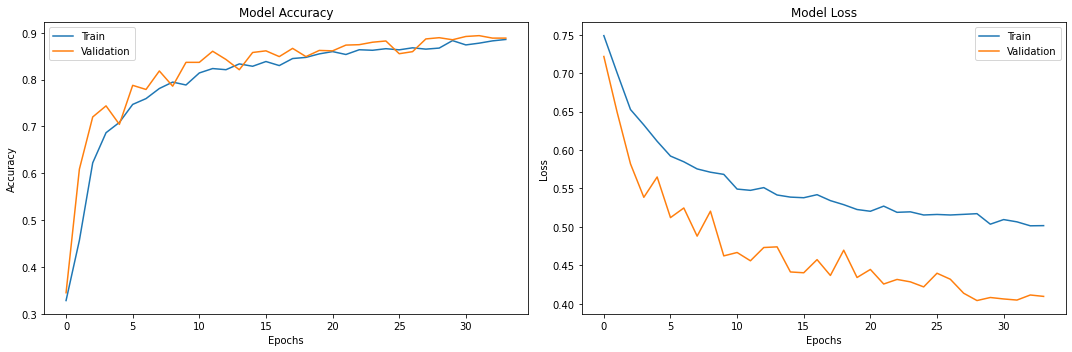

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']): 
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title(f'Model {met.capitalize()}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met.capitalize())
    ax[i].legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()